## Regression Application

This notebook applyies regression concepts and techniques to agricultural yield prediction. Through a series of steps, we'll analyse variable relationships, feature engineering, model construction, and evaluation, enhancing our understanding and proficiency in regression analysis.


# The data
Join us on an intriguing exploration of a vast agricultural dataset. Uncover the intricate connections between geographic, weather, soil, and farm management features, all leading to a prediction of yield. Our mission? To decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

## Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, otherwise the data import will fail.
 
[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)


In [2]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [ ]:
# Read the database, and clean the data using the processing modules we built.
import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor

# from weather_data_processor import WeatherDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [3]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts =============================
platform win32 -- Python 3.11.5, pytest-7.4.0, pluggy-1.0.0 -- c:\Users\klaig\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\klaig\Downloads
plugins: anyio-3.5.0
collecting ... collected 4 items

validate_data.py::test_read_field_dataframe_shape PASSED                 [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                    [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED     [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                       [100%]

============================== 4 passed in 6.60s ==============================
Deleted sampled_field_df.csv


## Understanding our variables and variable selection
In this section, we will analyse the predictor variables in our dataset and how they relate to the target variable.

### Step 1
Finding out how many predictors we originally have in our dataset, and which of these are categorical in nature.

In [54]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Field_ID           5654 non-null   int64  
 1   Elevation          5654 non-null   float64
 2   Latitude           5654 non-null   float64
 3   Longitude          5654 non-null   float64
 4   Location           5654 non-null   object 
 5   Slope              5654 non-null   float64
 6   Rainfall           5654 non-null   float64
 7   Min_temperature_C  5654 non-null   float64
 8   Max_temperature_C  5654 non-null   float64
 9   Ave_temps          5654 non-null   float64
 10  Soil_fertility     5654 non-null   float64
 11  Soil_type          5654 non-null   object 
 12  pH                 5654 non-null   float64
 13  Pollution_level    5654 non-null   float64
 14  Plot_size          5654 non-null   float64
 15  Annual_yield       5654 non-null   float64
 16  Crop_type          5654 

It appears there are 16 predictors; Location, Soil_type, and Crop_type are categorical.

### Step 2
The categorical features in our dataset need to be converted into a format suitable for modeling. We apply dummy variable encoding to these categorical features, then examine how many independent variables we now have.

We set the `drop_first` parameter to True.

In [4]:
'''
print(dataset['Location'].unique());
print('Locations: ', len(dataset['Location'].unique()));
print(dataset['Soil_type'].unique());
print('Soil types: ', len(dataset['Soil_type'].unique()));
print(dataset['Crop_type'].unique());
print('Crop types: ', len(dataset['Crop_type'].unique()));
'''
encoded_data = pd.get_dummies(dataset, drop_first=True)
# categorical_features = dataset.drop(columns=['Field_ID'])

# Count the number of independent variables
num_independent_variables = encoded_data.shape[1]
print("Number of independent variables after dummy variable encoding:", num_independent_variables)

encoded_data['Location_Rural_Amanzi'] = encoded_data['Location_Rural_Amanzi'].astype(int)
encoded_data['Location_Rural_Hawassa'] = encoded_data['Location_Rural_Hawassa'].astype(int)
encoded_data['Location_Rural_Kilimani'] = encoded_data['Location_Rural_Kilimani'].astype(int)
encoded_data['Location_Rural_Sokoto'] = encoded_data['Location_Rural_Sokoto'].astype(int)
encoded_data['Soil_type_Peaty'] = encoded_data['Soil_type_Peaty'].astype(int)
encoded_data['Soil_type_Rocky'] = encoded_data['Soil_type_Rocky'].astype(int)
encoded_data['Soil_type_Sandy'] = encoded_data['Soil_type_Sandy'].astype(int)
encoded_data['Soil_type_Silt'] = encoded_data['Soil_type_Silt'].astype(int)
encoded_data['Soil_type_Volcanic'] = encoded_data['Soil_type_Volcanic'].astype(int)
encoded_data['Crop_type_cassava'] = encoded_data['Crop_type_cassava'].astype(int)
encoded_data['Crop_type_coffee'] = encoded_data['Crop_type_coffee'].astype(int)
encoded_data['Crop_type_maize'] = encoded_data['Crop_type_maize'].astype(int)
encoded_data['Crop_type_potato'] = encoded_data['Crop_type_potato'].astype(int)
encoded_data['Crop_type_rice'] = encoded_data['Crop_type_rice'].astype(int)
encoded_data['Crop_type_tea'] = encoded_data['Crop_type_tea'].astype(int)
encoded_data['Crop_type_wheat'] = encoded_data['Crop_type_wheat'].astype(int)

encoded_data.info()

Number of independent variables after dummy variable encoding: 31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Field_ID                 5654 non-null   int64  
 1   Elevation                5654 non-null   float64
 2   Latitude                 5654 non-null   float64
 3   Longitude                5654 non-null   float64
 4   Slope                    5654 non-null   float64
 5   Rainfall                 5654 non-null   float64
 6   Min_temperature_C        5654 non-null   float64
 7   Max_temperature_C        5654 non-null   float64
 8   Ave_temps                5654 non-null   float64
 9   Soil_fertility           5654 non-null   float64
 10  pH                       5654 non-null   float64
 11  Pollution_level          5654 non-null   float64
 12  Plot_size                5654 non-null   float64
 13  Annual_yield

There seem to be 29 Variables (31 then exclude Standard_yield and FieldID (and Temperature_Range which gets added later))

### Step 3

From our encoded dataset, we seek to find out which variable has the third highest absolute correlation with the `Standard_yield`, excluding the variable itself.

In [56]:
#Get a dataframe for non numeric so that we can use .corr()
corr_matrix = encoded_data.corr()
#Print out the correlation values in descending order
print('Correlation with Standard Yield: \n', abs(corr_matrix['Standard_yield']).sort_values(ascending = False))

# Plot the correlation matrix as a heatmap
'''
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
'''

Correlation with Standard Yield: 
 Standard_yield             1.000000
Crop_type_tea              0.432879
Soil_type_Volcanic         0.309982
Pollution_level            0.285761
Crop_type_coffee           0.222217
Annual_yield               0.220812
Location_Rural_Sokoto      0.212337
Soil_type_Silt             0.205861
pH                         0.196613
Crop_type_cassava          0.186716
Crop_type_potato           0.175484
Soil_type_Sandy            0.164714
Min_temperature_C          0.144233
Temperature_Range          0.142012
Soil_type_Peaty            0.135509
Elevation                  0.129248
Max_temperature_C          0.111649
Location_Rural_Hawassa     0.110623
Crop_type_rice             0.104056
Crop_type_wheat            0.092420
Longitude                  0.085343
Soil_type_Rocky            0.078355
Soil_fertility             0.070205
Latitude                   0.061724
Slope                      0.056991
Rainfall                   0.039217
Location_Rural_Amanzi      0.

'\nplt.figure(figsize=(12, 10))\nsns.heatmap(corr_matrix, annot=True, cmap=\'coolwarm\', fmt=".2f", linewidths=0.5)\nplt.title(\'Correlation Matrix\')\nplt.show()\n'

It appears to be Pollution_level           (with 0.285761)

In order to fit an ordinary least squares regression model to our encoded data we would need to make sure that all our variables are numeric. Through dummy variable encoding, we converted our categorical variables to multiple int/boolean variables (depending on the environment you are working on). The `sm.OLS()` method itself does not inherently handle boolean data types implicitly.

In most cases, when fitting a model with sm.OLS(), it's essential to ensure that all features are numeric. If boolean columns are present, they should be explicitly converted to numeric types before fitting the model.

If we converted our columns to boolean datatypes, the boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.

### Step 4


SIn order to determine which of the predictors in our dataset are statistically significant. We will follow the following steps:

* Fit a statsmodels regression model to predict `Standard_yield` using our encoded dataset.
* Extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

In [7]:
formula_str = encoded_data.columns[14]+' ~ '+'+'.join(encoded_data.columns[:14])+'+'+'+'.join(encoded_data.columns[15:])
print(formula_str);
model=smf.ols(formula=formula_str, data=encoded_data)
fitted = model.fit();
print(fitted.summary())

Standard_yield ~ Field_ID+Elevation+Latitude+Longitude+Slope+Rainfall+Min_temperature_C+Max_temperature_C+Ave_temps+Soil_fertility+pH+Pollution_level+Plot_size+Annual_yield+Location_Rural_Amanzi+Location_Rural_Hawassa+Location_Rural_Kilimani+Location_Rural_Sokoto+Soil_type_Peaty+Soil_type_Rocky+Soil_type_Sandy+Soil_type_Silt+Soil_type_Volcanic+Crop_type_cassava+Crop_type_coffee+Crop_type_maize+Crop_type_potato+Crop_type_rice+Crop_type_tea+Crop_type_wheat
                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     602.9
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:33:04   Log-Likelihood:                 8360.5
No. Observations:                5654   AIC:                       

Since we have determined which variables are statistically significant for predicting `Standard_yield`, based on a p-value threshold of 0.05 `(p-value < 0.05)`, we proceed to building the model.

## Generating a multiple linear regression model

After encoding our variables and performing preliminary analysis, let's continue our efforts to identify the variables that will enable us to construct the most accurate multiple linear regression model possible with the data that we have.

### Step 5
Create a correlation matrix using all the columns in our encoded dataset and display it as a heatmap.<br>

In [1]:
# Generating and visualising the Correlation Matrix
plt.figure(figsize=(16, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

NameError: name 'plt' is not defined

### Step 6
Now that we have analysed our variables, let's fit an ordinary least squares regression model using `statsmodels.formula.api` and then print the model summary. Construct the model using all the independent variables in our encoded dataset (excuding `Field_ID`).<br>nt effect on the dependent variable.

In [9]:
formula_str2 = encoded_data.columns[14]+' ~ '+'+'.join(encoded_data.columns[1:14])+'+'+'+'.join(encoded_data.columns[15:])
print(formula_str2);
model2=smf.ols(formula=formula_str2, data=encoded_data)
fitted2 = model2.fit();
print(fitted2.summary())

Standard_yield ~ Elevation+Latitude+Longitude+Slope+Rainfall+Min_temperature_C+Max_temperature_C+Ave_temps+Soil_fertility+pH+Pollution_level+Plot_size+Annual_yield+Location_Rural_Amanzi+Location_Rural_Hawassa+Location_Rural_Kilimani+Location_Rural_Sokoto+Soil_type_Peaty+Soil_type_Rocky+Soil_type_Sandy+Soil_type_Silt+Soil_type_Volcanic+Crop_type_cassava+Crop_type_coffee+Crop_type_maize+Crop_type_potato+Crop_type_rice+Crop_type_tea+Crop_type_wheat
                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:33:07   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+

The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.

### Step 7

This summary  gives us an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.

To avoid this, let's reduce the number of independent variables included in our model.
Fit the model using the following variables:<br>

* `Pollution_level` 
* `Crop_type_coffee` 
* `Crop_type_tea`
* `Location_Rural_Sokoto`
* `Annual_yield` 
* `Soil_type_Silt`
* `Soil_type_Volcanic`

In [10]:
formula_str2 = encoded_data.columns[14]+' ~ '+'Pollution_level+Crop_type_coffee+Crop_type_tea+Location_Rural_Sokoto+Annual_yield+Soil_type_Silt+Soil_type_Volcanic'
print(formula_str2);
model2=smf.ols(formula=formula_str2, data=encoded_data)
fitted2 = model2.fit();
print(fitted2.summary())

Standard_yield ~ Pollution_level+Crop_type_coffee+Crop_type_tea+Location_Rural_Sokoto+Annual_yield+Soil_type_Silt+Soil_type_Volcanic
                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     552.1
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:33:07   Log-Likelihood:                 5839.8
No. Observations:                5654   AIC:                        -1.166e+04
Df Residuals:                    5646   BIC:                        -1.161e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025

After reducing the number of dependent variables accordingly, the R squared, adjusted R squared and F statistic all reduced. This implies that the model worsened.

### QStep 8
Let's evaluate our model's results. Generate a scatter plot of the residuals against the fitted values allowing us to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.

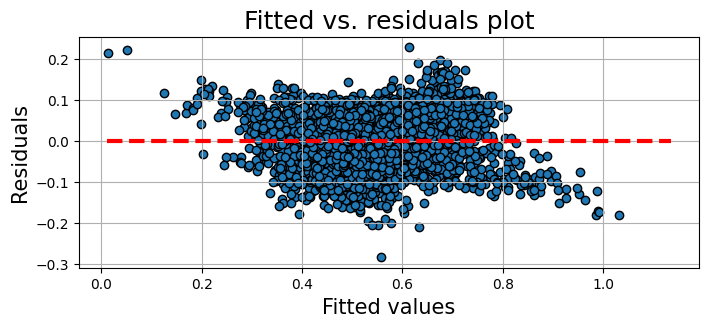

In [11]:
plt.figure(figsize=(8,3))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin = min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line.

Since the linear regression model indicated heteroscedasticity, the following actions could be considered to address this issue

* Applying transformations to the independent variables to better fit the linear relationship.
* Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals.
* Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals.

## Using regularisation to optimise agricultural yield

Continuing with our task, after fitting our model, we decide to go back to the drawing board to explore more ways to implement feature engineering and data pre-processing in order to optimise our model. We suspect that, if we use all the variables available to us, the model might overfit due to the high dimensionality of the data. Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.

### Step 10
Our first step in the feature engineering involves creating a new feature, `Temperature_Range`, and scaling features using `StandardScaler`. The difference between `Min_temperature_C` and `Max_temperature_C` is the temperature range.

In [12]:
from sklearn.preprocessing import StandardScaler

# Insert selected option here
dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']

# Select features for scaling (exclude non-numeric or target variables)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialise StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset[features])

# Show the first 5 rows of the scaled features
print(scaled_features[:5])

[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]


### Step 11


We then employ LASSO regression to identify predictive features associated with our dependent variable.

We implement the Python code block provided below.

In [13]:
from sklearn.linear_model import LassoCV

# scaled_features is our matrix of scaled features and dataset['Standard_yield'] is the target variable
lasso = LassoCV(cv=5).fit(scaled_features, dataset['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]

### Step 12

In trying to address multicollinearity in our dataset, we also decide to implement Ridge regression. After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero, we decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength. 

In [14]:
from sklearn.linear_model import RidgeCV

# Insert selected option here
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(scaled_features, dataset['Standard_yield'])

Answer: alphas = [0.001, 0.01, 0.1, 1, 10, 100]

### Step 13

Given our dataset includes variables such as `Elevation` and `Slope`, and considering the potential interactions between these variables might impact crop yield, we aim to capture both these interactions and possible non-linear relationships. We then create a quadratic interaction term without including an intercept in the feature set.

In [15]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(dataset[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
poly_features.shape


(5654, 5)

### Step 14

After implementing Ridge regression to address multicollinearity and prevent overfitting in our model we need to interpret the coefficients to understand the impact of each feature on the standard yield.

In [16]:
from sklearn.linear_model import Ridge
import numpy as np

# Assuming `X` is the feature matrix and `y` is the target variable
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
ridge_model.coef_


array([-0.13661379,  0.10262221, -0.07348657])

It appears that feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.

## Making a prediction using decision trees

After learning that decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, we decide to implement a decision tree on our encoded dataset.

### Step 15
Train a decision tree with the following specifications:
* Using our **previously encoded dataset**, split the data into dependent and independent variables using all the features except for `Standard_yield` and `Field_ID` as independent variables.
* Split the data into training and testing data.
* Use the `DecisionTreeRegressor` to fit a model using a `max_depth' of 2 and a `random_state` of 42.

Using the trained Decision Tree Regressor model, make a prediction for `y` given the following x-values:<br> 
`[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,`
`16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]`

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


y = encoded_data['Standard_yield']
X = encoded_data.drop(columns = ['Standard_yield', 'Temperature_range', 'Field_ID'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

dec_model = DecisionTreeRegressor(max_depth = 2, random_state = 42).fit(X_train, y_train)


input_array = np.array([864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006,
                        36.410000000000004, 16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,
                        0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0])

input_array = input_array.reshape(1, -1)

y_pred = dec_model.predict(input_array)
print(y_pred)

[0.48494414]


c:\Users\klaig\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


### Step 16

We calculate the model's RMSE to assess its performance

In [76]:
from sklearn import metrics

y_predictions = dec_model.predict(X_test)
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_predictions)))

RMSE:  0.08805783663217344


An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units

### Step 17
It is important to note that Higher max_depth values may lead to increased model complexity and a higher risk of overfitting. Let's attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.

In [77]:
dec_model = DecisionTreeRegressor(max_depth = 5, random_state = 42)
final = dec_model.fit(X_train, y_train)

y_predictions = final.predict(X_test)
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_predictions)))

RMSE:  0.06332974532698206


It appears that our model improved after setting it to 5.

## Ensemble Methods & Bootstrapping

Using our original dataset, our objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. We'll work with a subset of features from the dataset to predict the `Standard_yield`.

### Step 18
Consider the following approach to implement a bootstrap aggregation (bagging) for predicting the `Standard_yield` based on features `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`. Given are the steps and part of the Python code implementing this method. Our task is to identify the correct piece of code that completes the implementation.

The steps for the implementation are as follows:

1. Create an empty list named `predictions` to store predictions from each bootstrap sample.
2. Generate `n_bootstrap_samples` bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the `Standard_yield` on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.


Below is the code block with a missing part that needs to be completed:

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = dataset[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = dataset['Standard_yield']

predictions = []
n_bootstrap_samples = 100

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)

bagged_prediction = np.mean(predictions, axis=0)
mse_bagged = mean_squared_error(y, bagged_prediction)

print(f"Mean Squared Error of Bagged Linear Regression Models: {mse_bagged}")


Mean Squared Error of Bagged Linear Regression Models: 0.010840463278725836


### Step 19

We then implement the random subspace method by allowing the algorithm to select a random subset of features for each split.

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialise and train the random forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

# Predict using the random forest model
y_pred_rf = rf_model.predict(X)

# Evaluate the model
mse_rf = mean_squared_error(y, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")


Mean Squared Error of Random Forest Regressor: 0.001106288853809326


### Step 20

Consider the theoretical setup for a stacking ensemble model designed for a regression task. The first layer of this model includes three different types of regression models: linear regression, ridge regression, and a support vector machine (SVM) with a linear kernel. The second layer, or the final estimator, uses a linear regression model to combine the predictions from the first layer. The goal is to theoretically predict `Standard_yield` based on features such as `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`, with the intention to evaluate the model's hypothetical performance using the Mean Squared Error (MSE).

We then initialise the stacking ensemble model's setup to correctly configure the SVM with a linear kernel as part of the base learners in the stacking model.

In [22]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# Define base learners
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('svr', SVR(kernel='linear'))
]

# Define the theoretical stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Note: Assume X, y represent the features and target variable respectively, for a theoretical prediction scenario.

### Step 21

We then implement a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict `Standard_yield` and calculates the average Mean Squared Error (MSE) across all folds.

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialise the ridge regression model
ridge_model = Ridge()

# Perform 5-fold cross-validation with bootstrapping
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5) #add correct option here 

# Convert scores to positive MSE
mse_scores = -scores

# Calculate average MSE
average_mse = np.mean(mse_scores)
print(f"Average Mean Squared Error from Cross-Validation: {average_mse}")

Average Mean Squared Error from Cross-Validation: 0.010875483717316465


### Step 22

We then extract and print the feature importances from a trained random forest regressor model. The model is used to predict `Standard_yield` based on various features. The code utilises the `feature_importances_` attribute of the random forest model to obtain importance scores for each feature.

The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict Standard_yield. Higher scores suggest a greater contribution to the prediction.

In [24]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Elevation, Importance: 0.32232527035278535
Feature: Slope, Importance: 0.2175490659038575
Feature: Soil_fertility, Importance: 0.15288060187033797
Feature: Pollution_level, Importance: 0.30724506187301914


## Random forests
In this stint, we want to test how our data fits to a random forest model and other functionalities that come with its such as analysing feature importance.

We write a function named `train_rf_model` that trains and tests a random forest model on a given dataset. Our function does the following:

* Take a `RandomForestRegressor` object (with any desired hyperparameters set) as input,
* Separate the features `X` and target `y` dataframes
* Split the data into training and testing sets - use a test size of `20%` and a random state of `42` for reproducibility
* Fit the model to the training data
* Make predictions on the testing set
* Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

### Step 23
Using the function, train a random forest model on our dataset with random_state set to 42, and max_depth=15, while leaving all other hyperparameters at their defaults. We Use all the features available in the encoded dataset for this task to find the R-squared and MSE scores for the model on the test data.

In [79]:
from sklearn.metrics import r2_score

def train_rf_model(dataframe, n_estimators, MaxDepth, random_state):
    y = dataframe['Standard_yield']
    X = dataframe.drop(columns = ['Standard_yield', 'Field_ID'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    tree_m = RandomForestRegressor(n_estimators = n_estimators, max_depth = MaxDepth, random_state = 42)
    model = tree_m.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, r2, mse
'''           
X = encoded_data[['Standard_yield']]
y = encoded_data.drop(columns = ['Standard_yield', 'Field_ID'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

# Evaluate the model
mse_rf = mean_squared_error(y_test_scaled, y_pred_rf)
r2 = r2_score(y_test_scaled, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")
print(f"R Squared of Random Forest Regressor: {r2}")
'''
train_rf_model(encoded_data, 100, 15, 42)

(RandomForestRegressor(max_depth=15, random_state=42),
 0.9583058352928558,
 0.0005555925146927516)

Answer: R2: 0.9586, MSE: 0.0006

### Step 24

We want to examine how our data will fit to a random forest model when we tune the number of trees. We want to train and compare two random forest models with the same dataset as in the previous exercise. The first model should be trained with `150` trees, and the second model with `200` trees. Both models should use the default hyperparameters for all other settings, apart from a random_state of `42` to ensure reproducibility. 

In [51]:
def train_rf_model(dataframe, n_estimators,  random_state):
    y = dataframe['Standard_yield']
    X = dataframe.drop(columns = ['Standard_yield', 'Field_ID'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    tree_m = RandomForestRegressor(n_estimators = n_estimators, random_state = 42)
    model = tree_m.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, r2, mse
    
print(train_rf_model(encoded_data, 150, 42))
rfr_model, rfr_r2, rfr_mse = train_rf_model(encoded_data, 200, 42)
print(rfr_model, rfr_r2, rfr_mse)

(RandomForestRegressor(n_estimators=150, random_state=42), 0.9625025974267769, 0.00049966887060658)
RandomForestRegressor(n_estimators=200, random_state=42) 0.9625541789031138 0.0004989815254504688


After evaluating both models on the test set we find out that the model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.

One possible effect of increasing the number of trees in a random forest regression model is an increase in the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.

### Step 25

Following the training of our random forest models, we analyse the feature importance scores provided by the model built using 200 trees. Our aim is to identify which features the model considers most significant in predicting the target variable.

In [52]:
# Extract feature importances
feature_importances = rfr_model.feature_importances_

feature_names = X.columns
# Create a pandas Series 
importances = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)
sorted_importances

Rainfall                   0.203030
Crop_type_tea              0.182603
Latitude                   0.153801
pH                         0.120032
Elevation                  0.077331
Pollution_level            0.063107
Crop_type_rice             0.040436
Crop_type_coffee           0.039941
Crop_type_potato           0.025930
Crop_type_wheat            0.022131
Min_temperature_C          0.017992
Longitude                  0.010059
Crop_type_cassava          0.007828
Annual_yield               0.005470
Soil_type_Sandy            0.004663
Soil_type_Volcanic         0.004051
Temperature_Range          0.003504
Slope                      0.003293
Plot_size                  0.003062
Ave_temps                  0.002829
Max_temperature_C          0.002105
Soil_fertility             0.001960
Crop_type_maize            0.001944
Soil_type_Silt             0.001036
Soil_type_Rocky            0.000620
Soil_type_Peaty            0.000502
Location_Rural_Hawassa     0.000275
Location_Rural_Sokoto      0

A RandomForestRegressor with the parameters set as `n_estimators=150`, `max_depth=None` and `oob_score=True` will allow access and calculation of the Out-of-Bag (OOB) score for performance evaluation without requiring a separate validation set

Explanation:

The parameter oob_score set to True in the second option indicates that the Out-of-Bag (OOB) score will be calculated during the training of the random forest model. The OOB score is calculated using the samples not included in the bootstrap sample used to train each tree. Therefore, by enabling the oob_score parameter, you can access and evaluate the model's performance without requiring a separate validation set.